# CNN Auto Encoders

<br>

```
- A convolutional autoencoder (CNN autoencoder) is a type of autoencoder that uses convolutional neural networks (CNNs) to encode and decode data. 
- CNNs are a type of neural network that is specifically designed for processing data that has a spatial or temporal structure, such as images or videos.

CNN autoencoders are typically used for two main purposes:
1. Data compression: CNN autoencoders can be used to compress data by learning a compact representation of the data. This can be useful for tasks such as image compression or video compression.

2. Feature extraction: CNN autoencoders can be used to extract features from data. This can be useful for tasks such as image classification or object detection.

- It consists of:
  - Encoder.
  - Bottleneck/latent/code.
  - Decoder.

- The encoder compresses the input data into a lower dimensional representation.
- The decoder reconstructs the original data from the compressed represenation.
```

<br>

## Architecture

[![image.png](https://i.postimg.cc/hjjMjbrf/image.png)](https://postimg.cc/FfM0CSw4)

In [1]:
# Built-in library
import logging
from typing import Any, Optional, Sequence, Union

# Standard imports
import numpy as np
import numpy.typing as npt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as T
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Configure the backend
import matplotlib_inline.backend_inline

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 2_000

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
import seaborn as sns

# Custom import
from src.utilities import (
    set_up_logger,
    create_iris_data,
    create_qwerties_data,
    smooth,
)
from src.data_manager import (
    load_data,
    create_data_loader,
    split_into_train_n_validation,
)
from src.preprocessor import Standardizer, Normalizer


# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

## CIFAR10 Data

<br>

### Load CIFAR10 Data

In [2]:
cifar10_fp = "../../data/cifar10/"

transform = T.Compose(
    [
        # Convert to PyTorch tensors
        T.ToTensor(),
        # Normalize [-1 to +1]
        T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
)
train_dataset = CIFAR10(root=cifar10_fp, train=True, transform=transform, download=True)
test_dataset = CIFAR10(root=cifar10_fp, train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Dimension of the data
train_dataset.data.shape, test_dataset.data.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [4]:
### Hyper-parameters
# Each MNSIT image is 3x32x32, so it is an 2D array [32,32]
# I'll flatten the image as vector dim=3*32*32
input_size = 3 * 32 * 32
num_epochs = 5
batch_size = 64
learning_rate = 0.001

In [5]:
train_size = int(0.8 * len(train_dataset))  # 80% of training data
val_size = len(train_dataset) - train_size  # 20% of training data

# Split the training dataset into training and validation sets
train_dataset, val_dataset = random_split(
    dataset=train_dataset,
    lengths=[train_size, val_size],
)

# Create DataLoader for each dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### Note

```text
- If the min and max values are 0 and 1, the activation function at the output layer is `Sigmoid`.
- If the min and max values are -1 and 1, the activation function at the output layer is `Tangent Hyperbolic`.
```

In [6]:
X, y = next(iter(train_loader))


print(f"Min: {torch.min(X)}\nMax: {torch.max(X)}")

Min: -1.0
Max: 1.0


## Build CNN Autoencoder

In [7]:
class CNNAutoencoder(nn.Module):
    """This is used to build a Convolutional Neutral Network Autoencoder
    architecture that is used for image compression.

    Params:
        input_size: This is the output of the final conv layer.
        num_classes (int): This is the number of class labels in the input data.
    """

    def __init__(self) -> None:
        super().__init__()
        # ====== Encoder ======
        # 16 to 64
        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=5, stride=2, padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=1
            ),
            nn.ReLU(),
        )

        # ====== Decoder ======
        # 64 to 16
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=64, out_channels=32, kernel_size=5, stride=2, padding=1
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=32, out_channels=16, kernel_size=5, stride=2, padding=1
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=16,
                out_channels=3,
                kernel_size=5,
                stride=2,
                padding=1,
                output_padding=1,  # This ensures the original image == decoded image
            ),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """This performs the forward propagation."""
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [8]:
# Test the model with random data
# (1_000, 3, 32, 32): (n_samples, n_channels, image_size, image_size)
cnn_model = CNNAutoencoder()
X_ = torch.rand(size=(1_000, 3, 32, 32))

result = cnn_model.forward(x=X_)
result.shape

torch.Size([1000, 3, 32, 32])

In [9]:
def train(
    model: CNNAutoencoder,
    device: Any,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: Any,
    optimizer: torch.optim,
    num_epochs: int,
) -> CNNAutoencoder:
    """This is used for training the model."""
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0

        # ==== Batch training loop ====
        for data in train_loader:
            images, _ = data
            # Push the data to GPU if available
            images = images.to(device)

            # ==== Forward prop ====
            # Compare the decoded image w/the original image
            outputs = model(images)
            loss = criterion(outputs, images)

            # ==== Backprop ====
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Update the loss
            running_loss += loss.item()

        # ==== Validation loop ====
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for data in val_loader:
                images, _ = data
                # Push the data to GPU if available
                images = images.to(device)
                outputs = model(images)
                # Compare the decoded image w/the original image
                val_loss = criterion(outputs, images).item()

        print(
            f"Epoch {epoch + 1}/{num_epochs}, "
            f"Training Loss: {running_loss / len(train_loader)}, "
            f"Validation Loss: {val_loss / len(val_loader)} "
        )
    return model

In [10]:
def main():
    """This is the main function."""
    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # If we're on a CUDA machine, this should print a CUDA device:
    print(f"Working on device={device!r}")

    # ==== Init model ====
    model = CNNAutoencoder().to(device=device)

    # ==== Define loss function and optimizer ====
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        params=model.parameters(), lr=learning_rate, weight_decay=1e-5
    )

    # ==== Train the model ====
    model = train(
        model,
        device=device,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=num_epochs,
    )
    return model

In [11]:
trained_model = main()

Working on device=device(type='cpu')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5, Training Loss: 0.16736686735153197, Validation Loss: 0.0009615114729875212 
Epoch 2/5, Training Loss: 0.1517631289601326, Validation Loss: 0.0009321716560679636 
Epoch 3/5, Training Loss: 0.1496574862599373, Validation Loss: 0.0009187745630361472 
Epoch 4/5, Training Loss: 0.14825608028173445, Validation Loss: 0.0009092526261214238 
Epoch 5/5, Training Loss: 0.1473932855606079, Validation Loss: 0.0009063080807400357 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


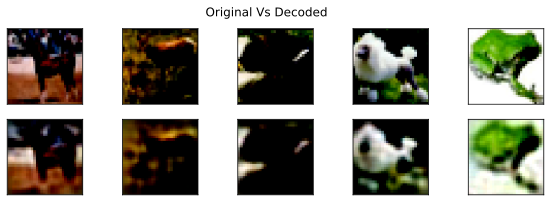

In [12]:
# Repeat the visualization when testing the model
X, _ = next(iter(train_loader))
sample_data = X[:5, :]
y_pred = trained_model(sample_data).detach()


# let's see what the model did!
fig, axs = plt.subplots(2, 5, figsize=(10, 3))

for idx in range(5):
    axs[0, idx].imshow(sample_data[idx, :].permute(1, 2, 0), cmap="gray")
    axs[1, idx].imshow(y_pred[idx, :].permute(1, 2, 0), cmap="gray")
    axs[0, idx].set_xticks([]), axs[0, idx].set_yticks([])
    axs[1, idx].set_xticks([]), axs[1, idx].set_yticks([])

plt.suptitle("Original Vs Decoded")
plt.show()